In [1]:
import pandas as pd
import numpy as np

from os.path import dirname, basename, exists
import glob as glob

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
bucket_path = sorted(glob.glob('/data/bswift-1/Pessoa_Lab/MAX/dataset/positive_runs/MAX???/ROI_analysis/MAX???_Main_block_Deconv_bucket.1D'))

In [3]:
rois = ['ACC','vmPFC','Right PAG','Left PAG','Right BST','Left BST',
        'Right Ventral Striatum','Left Ventral Striatum','Right Posterior Putamen',
        'Left Posterior Putamen','Right Anterior Putamen','Left Anterior  Putamen',
        'Right Posterior Caudate','Left Posterior Caudate', 'Right Anterior Caudate',   
        'Left Anterior Caudate','Right AntVentral Insula','Right MidPost Insula',
        'Left AntVentral Insula','Left MidPost Insula','Right AntDorsal Insula',
        'Left AntDorsal Insula','Right CeMe Amygdala','Left CeMe Amygdala',
        'Right BLBM Amygdala','Left BLBM Amygdala','PCC','PCC/precuneus',
        'Left Posterior Thalamus','Right Posterior Thalamus','Left Anterior MCC',
        'Right Anterior MCC','Left Anterior Thalamus','Right Anterior Thalamus',
        'Left Hypothalamus','Right Hypothalamus']

In [4]:
def make_df(subj,vals,index,columns):
    safe = pd.DataFrame(vals[:,:17],index=rois,columns=t).T
    safe['Type'] = 'safe'
    threat = pd.DataFrame(vals[:,17:34],index=rois,columns=t).T
    threat['Type'] = 'threat'
    tmp_df = pd.concat([threat,safe])
    tmp_df['Subj'] = subj
    tmp_df.index.name = 'Time'
    tmp_df.reset_index(inplace=True)
    return tmp_df

In [5]:
df = pd.DataFrame()
t = np.arange(17)*1.25
for path in bucket_path:
    subj = basename(path).split('_')[0]
    
    beta = np.loadtxt(path)[:len(rois),1::2]
    tstat = np.loadtxt(path)[:len(rois),2::2]
    
    var = (beta/tstat)**2
    
    tmp_df_beta = make_df(subj,beta,index=rois,columns=t)
    tmp_df_beta = pd.melt(tmp_df_beta,
                          id_vars=['Subj','Type','Time'],
                          var_name='ROI',
                          value_name='beta')
    tmp_df_var = make_df(subj,var,index=rois,columns=t)
    tmp_df_var = pd.melt(tmp_df_var,
                          id_vars=['Subj','Type','Time'],
                          var_name='ROI',
                          value_name='var')
    tmp_df = pd.merge(tmp_df_beta,tmp_df_var)
    
    df = pd.concat([df,tmp_df],ignore_index=True)

In [6]:
df.head()

,Subj,Type,Time,ROI,beta,var
0,MAX116,threat,0.00,ACC,-0.134109,0.035129
1,MAX116,threat,1.25,ACC,-0.485728,0.067990
2,MAX116,threat,2.50,ACC,-0.255640,0.089839
3,MAX116,threat,3.75,ACC,-0.085234,0.103253
4,MAX116,threat,5.00,ACC,-0.043984,0.113570


In [7]:
from scipy.stats import sem
from scipy.stats import t as tdist
N = len(bucket_path)
critT = tdist(df=N-1).ppf(0.975)

In [8]:
mean_df = df.groupby(['Type','ROI','Time'])['beta'].agg([np.mean,sem]).reset_index()

In [9]:
mean_df['lower_bound'] = mean_df['mean'] - critT*mean_df['sem']
mean_df['upper_bound'] = mean_df['mean'] + critT*mean_df['sem']

In [10]:
mean_df.head()

,Type,ROI,Time,mean,sem,lower_bound,upper_bound
0,safe,ACC,0.00,-0.028354,0.012323,-0.052897,-0.003810
1,safe,ACC,1.25,-0.041921,0.015504,-0.072799,-0.011043
2,safe,ACC,2.50,-0.047291,0.016543,-0.080239,-0.014344
3,safe,ACC,3.75,-0.035399,0.017493,-0.070240,-0.000558
4,safe,ACC,5.00,-0.039190,0.018106,-0.075252,-0.003129


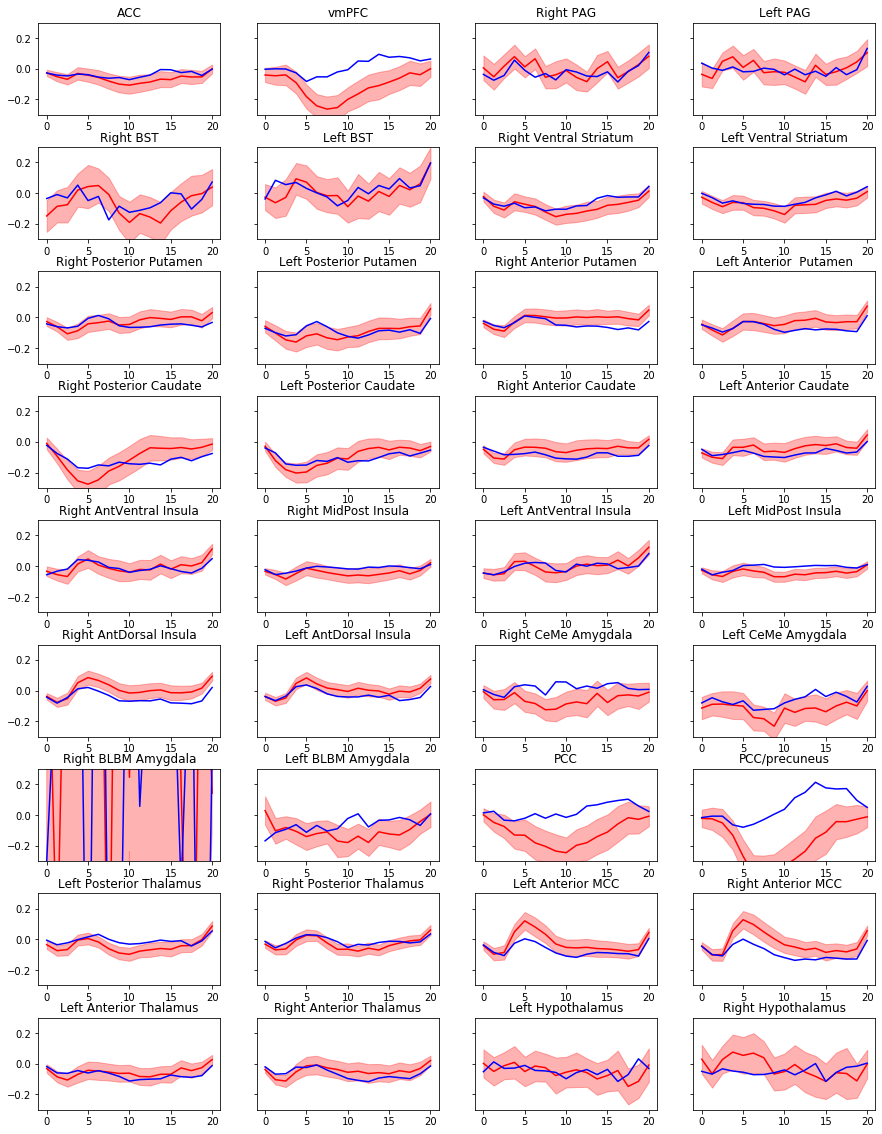

In [11]:
fig, axes = plt.subplots(nrows=9,ncols=4,figsize=(15,20),sharey=True)
axes = axes.flatten()

fig.subplots_adjust(wspace=0.2,hspace=0.35)

for i, roi in enumerate(rois):
    threat_df = mean_df[(mean_df['ROI']==roi) & (mean_df['Type']=='threat')]
    safe_df = mean_df[(mean_df['ROI']==roi) & (mean_df['Type']=='safe')]
    axes[i].plot(t,threat_df['mean'],label='threat',color='red')
    axes[i].fill_between(t,threat_df['lower_bound'],threat_df['upper_bound'],alpha=0.3,color='red')
    axes[i].plot(t,safe_df['mean'],label='safe',color='blue')
    #axes[i].fill_between(t,safe_df['lower_bound'],safe_df['upper_bound'],alpha=0.3,color='blue')
    axes[i].set_title(roi)
    axes[i].set_ylim([-0.3,0.3])

In [12]:
df.to_csv('MAX_positive_estimated_responses.txt',sep=',',index=False,float_format='%0.4f')
mean_df.to_csv('MAX_positive_mean_estimated_responses.txt',sep=',',index=False,float_format='%0.4f')